In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

#imported for executing more statements in the same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Prvo sam istražio kako pristupiti financijskim podatcima o vrijednostima dionica kroz vrijeme
Odlučio sam se iskoristiti pyhton biblioteku YFinance
Moguće je dohvatiti podatke za sve kompanije, ja sam se odlučio u ovom projektu testirati funkcionalnosti
nad dionicama kompanije Apple 'AAPL'

In [2]:
appleData = yf.download(' AAPL', start="2017-01-01", end="2022-10-25")
appleDf = pd.DataFrame(appleData)
appleDf.to_csv("apple.csv")

[*********************100%***********************]  1 of 1 completed


-Spremio sam podatke u csv file "apple.csv"

In [3]:
apple_df = pd.read_csv("apple.csv")
apple_df.columns


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

Prvo sam očitao atribute odnosno stupce dohvaćenog dataframea, vidljivo je da nema indexa te ga treba odabrati
,to će naravno biti 'Date' atribut

In [4]:
apple_df = pd.read_csv("apple.csv")
apple_df.set_index('Date' , inplace=True)
apple_df.shape
apple_df.info

(1463, 6)

<bound method DataFrame.info of                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2017-01-03   28.950001   29.082500   28.690001   29.037500   27.174749   
2017-01-04   28.962500   29.127501   28.937500   29.004999   27.144342   
2017-01-05   28.980000   29.215000   28.952499   29.152500   27.282377   
2017-01-06   29.195000   29.540001   29.117500   29.477501   27.586535   
2017-01-09   29.487499   29.857500   29.485001   29.747499   27.839207   
...                ...         ...         ...         ...         ...   
2022-10-18  145.490005  146.699997  140.610001  143.750000  143.511932   
2022-10-19  141.690002  144.949997  141.500000  143.860001  143.621750   
2022-10-20  143.020004  145.889999  142.649994  143.389999  143.152527   
2022-10-21  142.869995  147.850006  142.649994  147.270004  147.026108   
2022-10-24  147.190002  150.229996  146.000000  149.449997  149.202484   

     

In [5]:
apple_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,28.950001,29.082500,28.690001,29.037500,27.174749,115127600
2017-01-04,28.962500,29.127501,28.937500,29.004999,27.144342,84472400
2017-01-05,28.980000,29.215000,28.952499,29.152500,27.282377,88774400
2017-01-06,29.195000,29.540001,29.117500,29.477501,27.586535,127007600
2017-01-09,29.487499,29.857500,29.485001,29.747499,27.839207,134247600


Uz date kojim smo indeksirali ovaj dataframe raspoolažemo jos s nekolicnom podataka:
-Open(ulazna cijena dionice za određen dan u trenutku otvaranja trgovine dionicama)
-High(najviša cijena dana)
-Low(Najniža cijena dana)
-Close(cijena pri zatvaranju trgovine dionicama za određeni dan)
-Adjusted close (cijena slična close nad kojom se još provode daljnje operacije kako bi se dobila točnija
vrijednost za kraj dana)
-Volume(broj tradeova odnosno kupovina/prodaja te dionice na taj dan)

Nadalje vidljivo je da ne postoje retci za sve datume odnosno ima dana kada je trziste zatvoreno ,a to je vikendima
te drzavnim praznicima

In [6]:
apple_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1463.000000,1463.000000,1463.000000,1463.000000,1463.000000,1.463000e+03
mean,86.211328,87.217010,85.261377,86.283218,84.825896,1.165143e+08
std,47.610600,48.246571,46.985790,47.637990,48.039583,5.397545e+07
min,28.950001,29.082500,28.690001,29.004999,27.144342,4.100000e+07
25%,43.746250,43.983749,43.483749,43.751249,41.963221,8.139260e+07
50%,64.192497,64.882500,63.237499,64.375000,62.877964,1.023892e+08
75%,133.415001,134.665001,131.639999,133.110001,131.879066,1.350912e+08
max,182.630005,182.940002,179.119995,182.009995,180.959747,4.479400e+08


Vidljivo je da su sve numeričke vrijednosti što je pogodno za regresijske algoritme strojnog učenja, također je vidljivo da nema stršećih vrijednosti

In [7]:
apple_df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Nema nedostajućih vrijednosti, te stoga ne moramo izbacivati nijedan atribut odnosno postavljati ga na neku srednju
vrijednost

<AxesSubplot: xlabel='Date'>

Text(0, 0.5, 'Adjusted Close Prices')

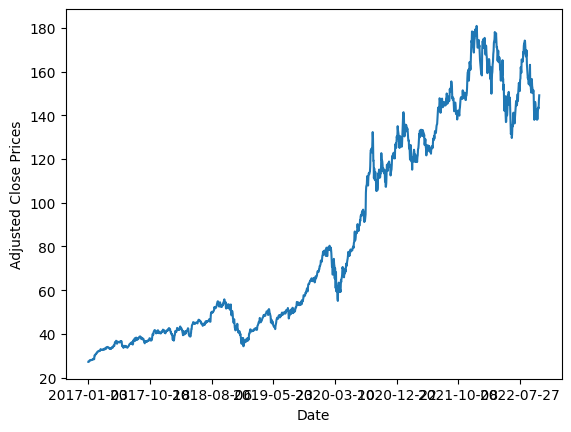

In [8]:
from matplotlib import pyplot as plt

apple_df['Adj Close'].plot()
plt.ylabel("Adjusted Close Prices")
plt.show()

Grafom sam prikazao kako se kretao Adjusted close kroz vrijeme, gdje vidimo uzlazne i silazne trendove

PRVI ALGORITAM KOJI ĆU PROVESTI JEST MOVING AVERAGE
Algortam predviđa vrijednost na temelju srednje vrijednosti prethodno promatranih vrijednosti

In [9]:
#prvo treba smanjiti broj atributa na samo 'date' i 'adjusted close' zato što ćemo izračunavati srednju vrijednost
#adjusted close atributa

apple_df = pd.read_csv("apple.csv")
apple_df['Date'] = pd.to_datetime(apple_df.Date, format='%Y-%m-%d')
apple_df.index = apple_df['Date']
old_apple_df = apple_df.sort_index(ascending=True, axis=0)
new_apple_df = pd.DataFrame(index=range(0, len(apple_df)), columns=['Date', 'Adj Close'])

for i in range(0, len(old_apple_df)) :
    new_apple_df['Date'][i] = old_apple_df['Date'][i]
    new_apple_df['Adj Close'][i] = old_apple_df['Adj Close'][i]

new_apple_df.shape
new_apple_df.head()

(1463, 2)

,Date,Adj Close
0,2017-01-03 00:00:00,27.174749
1,2017-01-04 00:00:00,27.144342
2,2017-01-05 00:00:00,27.282377
3,2017-01-06 00:00:00,27.586535
4,2017-01-09 00:00:00,27.839207


Reducirao sam stupce samo na Date i Adjusted close

In [10]:

new_apple_df['Date'] = pd.to_datetime(new_apple_df.Date,format='%Y-%m-%d')
new_apple_df.index = new_apple_df['Date']

#best proportion of train and test set is 80:20 so i divided these two sets:
# train first 1149 rows, test other 315 rows

train = new_apple_df[: 1148]
test = new_apple_df[1148:]

# shapes of training set
print('\n Shape of training set:')
print(train.shape)

# shapes of test set
print('\n Shape of test set:')
print(test.shape)
train['Date']

preds = []
for i in range(0,test.shape[0]):
    a = train['Adj Close'][len(train)-315+i:].sum() + sum(preds)
    b = a/315
    preds.append(b)

# checking the results (RMSE value)
rms=np.sqrt(np.mean(np.power((np.array(test['Adj Close'])-preds),2)))
print('\n RMSE value on validation set:')
print(rms)



 Shape of training set:
(1148, 2)

 Shape of test set:
(315, 2)


Date
2017-01-03   2017-01-03
2017-01-04   2017-01-04
2017-01-05   2017-01-05
2017-01-06   2017-01-06
2017-01-09   2017-01-09
                ...    
2021-07-20   2021-07-20
2021-07-21   2021-07-21
2021-07-22   2021-07-22
2021-07-23   2021-07-23
2021-07-26   2021-07-26
Name: Date, Length: 1148, dtype: datetime64[ns]


 RMSE value on validation set:
33.60723246667659


/var/folders/4j/1szjylzj6w92zhlstrybjdwr0000gn/T/ipykernel_78735/1742379680.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:,'Predictions'] = 0
/var/folders/4j/1szjylzj6w92zhlstrybjdwr0000gn/T/ipykernel_78735/1742379680.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:,'Predictions'] = preds


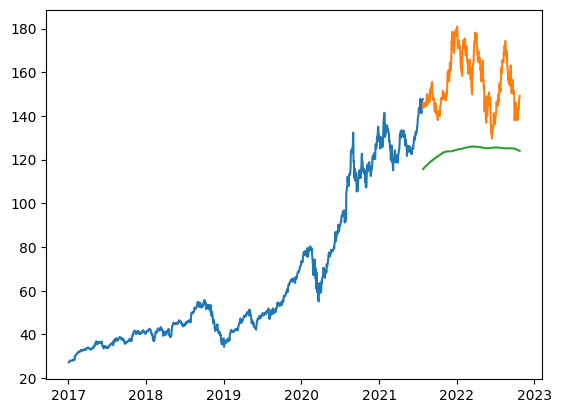

In [11]:
#plot
test.loc[:,'Predictions'] = 0
test.loc[:,'Predictions'] = preds
plt.plot(train['Adj Close'])
plt.plot(test[['Adj Close', 'Predictions']])

Plavi graf prikazuje Adj close vrijednost train seta, narancasti prikazuje Adj close koja je stvarna na
test setu, dok zelena crta prikazuje predikcije MA algoritmom što uvelike odstupa od stvarnih vrijednosti.

LINEARNI REGRESIJSKI ALGORTIAM

In [17]:
pd.options.mode.chained_assignment = None

#create features
from fastai.tabular.all import  add_datepart

apple_df = pd.read_csv("apple.csv")
apple_df['Date'] = pd.to_datetime(apple_df.Date, format='%Y-%m-%d')
apple_df.index = apple_df['Date']
old_apple_df_LR = apple_df.sort_index(ascending=True, axis=0)
new_apple_df_LR = pd.DataFrame(index=range(0, len(apple_df)), columns=['Date', 'Adj Close'])

for i in range(0, len(old_apple_df)) :
    new_apple_df_LR['Date'][i] = old_apple_df_LR['Date'][i]
    new_apple_df_LR['Adj Close'][i] = old_apple_df_LR['Adj Close'][i]

add_datepart(new_apple_df_LR, 'Date')
new_apple_df_LR.drop('Elapsed', axis=1, inplace=True)

new_apple_df_LR.loc[:,'mon_fri'] = 0
for i in range(0,len(new_apple_df_LR)):
    if (new_apple_df_LR.loc[i,'Dayofweek']== 0 or new_apple_df_LR.loc[i,'Dayofweek']== 4):
        new_apple_df_LR.loc[i,'mon_fri'] = 1
    else:
        new_apple_df_LR.loc[i,'mon_fri'] = 0


train_LR = new_apple_df_LR[:1148]
test_LR = new_apple_df_LR[1148:]

x_train_LR = train_LR.drop('Adj Close', axis=1)
y_train_LR = train_LR['Adj Close']
x_test_LR = test_LR.drop('Adj Close', axis=1)
y_test_LR = test_LR['Adj Close']


#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train_LR,y_train_LR)

preds = model.predict(x_test_LR)
rms=np.sqrt(np.mean(np.power((np.array(y_test_LR)-np.array(preds)),2)))
print(rms)

,Adj Close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,27.174749,2017,1,1,3,1,3,False,False,False,False,False,False,1.483402e+09
1,27.144342,2017,1,1,4,2,4,False,False,False,False,False,False,1.483488e+09
2,27.282377,2017,1,1,5,3,5,False,False,False,False,False,False,1.483574e+09
3,27.586535,2017,1,1,6,4,6,False,False,False,False,False,False,1.483661e+09
4,27.839207,2017,1,2,9,0,9,False,False,False,False,False,False,1.483920e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458,143.511932,2022,10,42,18,1,291,False,False,False,False,False,False,1.666051e+09
1459,143.62175,2022,10,42,19,2,292,False,False,False,False,False,False,1.666138e+09
1460,143.152527,2022,10,42,20,3,293,False,False,False,False,False,False,1.666224e+09
1461,147.026108,2022,10,42,21,4,294,False,False,False,False,False,False,1.666310e+09


LinearRegression()

27.997324250164837


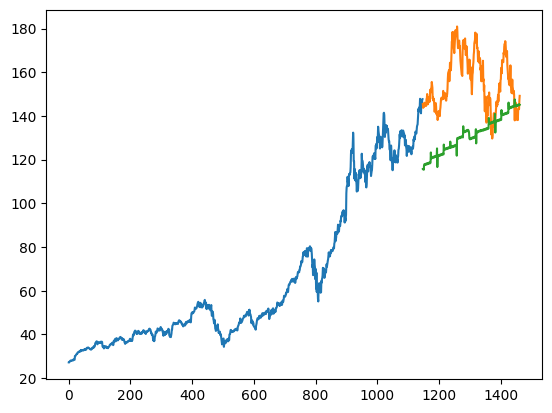

In [18]:
pd.options.mode.chained_assignment = None  # default='warn'

#plot
test_LR['Predictions'] = 0
test_LR['Predictions'] = preds


test_LR.index = new_apple_df_LR[1148:].index
train_LR.index = new_apple_df_LR[:1148].index

plt.plot(train_LR['Adj Close'])
plt.plot(test_LR[['Adj Close', 'Predictions']])

Zelena boja na grafu prikazuje uzlazni trend vrijednosti no nije to još ni približno točno,
glavni nedostatak Linearnog regresijskog algoritma jest to što je prenaučen za stupce date i month, koje smo dobili
s onim featureom add_datepart, te stoga umjesto da se usredotoči na prethodne vrijednosti s mjesta predikcije
on će gledati vrijednost istog mje

K-nearest neighbours, radi na principu k najbližih susjeda u odnosu na index pretraživanja, npr.
ako želimo odrediti visinu osoba u određenoj godini starosti, godina starosti jest index pretraživanja te ćemo naći k najbližih susjeda i uzeti srednju vrijednost

In [19]:
#importing libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [23]:
#scaling data
x_train_scaled_knn = scaler.fit_transform(x_train_LR)
x_train_knn = pd.DataFrame(x_train_scaled_knn)
x_test_scaled_knn = scaler.fit_transform(x_test_LR)
x_test_knn = pd.DataFrame(x_test_scaled_knn)

train_KNN = train_LR
test_KNN = test_LR

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train_knn ,y_train_LR)
preds = model.predict(x_test_knn)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]})

In [24]:
#rmse
rms=np.sqrt(np.mean(np.power((np.array(y_test_LR)-np.array(preds)),2)))
rms

73.79179516351657

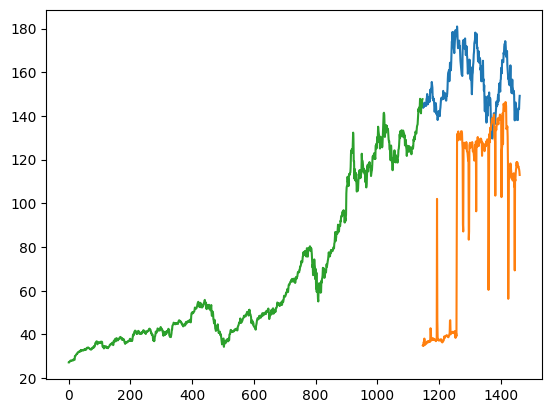

In [26]:
#plot
test_KNN['Predictions'] = 0
test_KNN['Predictions'] = preds
plt.plot(test_KNN[['Adj Close', 'Predictions']])
plt.plot(train_KNN['Adj Close'])

U sva 3 slučaja rmse(prosjecna razlika između očekivane i predviđene vrijednosti) nije bio prevelik, no vidljivo je da ova 3 jednostavna regresijska algoritma
nemaju dobre perfomanse na ovom datasetu.